In [2]:
import pandas as pd

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [5]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [6]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [9]:
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from google.colab import files
files.upload()

df = spark.read.csv('BostonHousing.csv',inferSchema=True, header=True)

from pyspark.ml.feature import VectorAssembler

df.columns


Saving BostonHousing.csv to BostonHousing.csv


['crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat',
 'medv']

In [10]:
inputCols = [
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'b',
 'lstat'
]

only_features= ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
assembler= VectorAssembler(inputCols=only_features,outputCol='features')

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

feat_df=assembler.transform(df).select('features')

In [12]:
scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(feat_df)
df_scaled=scaler.transform(feat_df)
df_scaled.show(5)

n_components=2
pca=PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('explained variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)

X_pca=df_pca.rdd.map(lambda row:row.pcafeatures).collect()
X_pca=np.array(X_pca)

X_pca

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows

explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+---------

array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



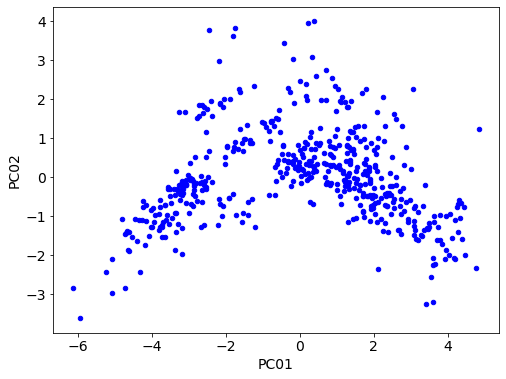

In [22]:
df_pca=pd.DataFrame(X_pca, columns=['PC01','PC02'])
df_pca.head()

plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=df_pca.plot.scatter(x='PC01',y='PC02',c='Blue')

output=assembler.transform(df)
f_data=output.select('features','medv')
f_data.show(5)

In [23]:
train_data,test_data= f_data.randomSplit([0.90,0.1])


In [24]:
regressor=LinearRegression(featuresCol='features',labelCol='medv')
regressor=regressor.fit(train_data)

In [26]:
coeff=regressor.coefficients
intr=regressor.intercept
print("The coefficient of the model is :", coeff)
print("The intercept of the model is :", intr)

print("The coefficient of the model is : %a" %coeff)
print("The intercept of the model is : %f" %intr)


The coefficient of the model is : [-0.10788394039623744,0.0423824228848935,0.01409516147411452,3.213851071683925,-19.253458136428872,3.5768625561674305,0.004179137763796968,-1.4742119510554161,0.33006732601273736,-0.013098900864430994,-0.9461763110125307,0.009362984877064686,-0.5264846405727813]
The intercept of the model is : 38.607022320358844
The coefficient of the model is : DenseVector([-0.1079, 0.0424, 0.0141, 3.2139, -19.2535, 3.5769, 0.0042, -1.4742, 0.3301, -0.0131, -0.9462, 0.0094, -0.5265])
The intercept of the model is : 38.607022


In [27]:
pred = regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01778,95.0,1.4...|32.9|30.084066164344478|
|[0.03306,0.0,5.19...|20.6|22.327057832522403|
|[0.0351,95.0,2.68...|48.5| 41.48781959010303|
|[0.03551,25.0,4.8...|22.9|25.186966899374802|
|[0.04337,21.0,5.6...|20.5|24.174550250893606|
+--------------------+----+------------------+
only showing top 5 rows



In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='medv',predictionCol='prediction',metricName='rmse')

In [29]:
rmse=eval.evaluate(pred.predictions)
print("RMSE : %.3f" %rmse)

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("MSE : %.3f" %mse)

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("MAE : %.3f" % mae)

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("r2 : %.3f" %r2)

RMSE : 4.047
MSE : 16.377
MAE : 2.961
r2 : 0.779
